In [1]:
import pandas as pd
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt
import random
import seaborn as sns
import itertools
import os
from PIL import Image
import math
from matplotlib import gridspec
import matplotlib.collections

from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
import matplotlib.collections

from sklearn.model_selection import *

from tqdm import *
# nice progress bars otherwise
# def tqdm(x):
#     yield x

In [2]:
# TODO, improvement ideas

# use log(flux) as input
# investigate highest errors (argmax(xi²))

# kfold integration in place of CV
# TTA
# CNN segmentation cleanup 
# resnet v2 ( https://github.com/myutwo150/keras-inception-resnet-v2/blob/master/inception_resnet_v2.py )
# custom CNN features
# CV2 resize cubic interpolation 

# Serge:
# essayer de remplacer lgb par un Deep NN keras (vu la quantité de donnée)


#done
# lgbm eval rmsle instead of rmse
# add image size as feature



In [3]:
# memory debug function

import sys
# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
mm = sorted([(x, sys.getsizeof(globals().get(x)),"{:,}".format(sys.getsizeof(globals().get(x)))) 
        for x in dir() 
           if not x.startswith('_') 
#         and x not in sys.modules
        and x not in ipython_vars], key=lambda x: x[1], reverse=True)




## data folder set up and test

In [4]:
dataFolder = 'data/mainData/'
plt.ion()

runNameParams = []
runNameParams.append('newSource')
# print(runNameParams)

In [5]:
def read_image(id):
    if id[-4:] == '.npy':
        X = np.load(dataFolder+id)
    elif os.path.isfile(dataFolder+id+'.npy'):
        X = np.load(dataFolder+id + '.npy')
    elif os.path.isfile(dataFolder+id+'-g.csv'):
        X = np.genfromtxt(dataFolder+id+'-g.csv', delimiter=",")
    else:
        X = None

    X = np.float32(X)
    return X


In [6]:
dataFileList = []

directory = os.fsencode(dataFolder)

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".npy") or filename.endswith(".py"): 
        dataFileList.append(filename)
        
print(len(dataFileList))

80306


# Check a few random images 


In [7]:
def drawOneGalaxy(galaxyID):
    oneImageData = read_image(galaxyID)
    print(galaxyID)

    # new image
    fig = plt.figure(figsize=(15,15))
    #set grid spec for the 4 graphs
    gs = gridspec.GridSpec(2, 2, width_ratios=[5, 1], height_ratios=[1,5]) 

    #draw image
    plt.title("raw")
    plt.subplot(gs[2])
    plt.imshow(oneImageData)
    
    # horizontal (top) sum
    plt.subplot(gs[0])
    plt.title(galaxyID)
    plt.plot(oneImageData.sum(axis=0))

    # vertical (bottom-right) sum
    ax = plt.subplot(gs[3])
    ss = np.flip(oneImageData.sum(axis=1),axis=0)
    plt.scatter(x=ss, y=list(range(oneImageData.shape[1])), s=1)
    lines = [[(ss[i-1],i-1),(ss[i],i)] for i in range(1,len(ss))]
    lc = matplotlib.collections.LineCollection(lines)
    ax.add_collection(lc)
    
    #value histogram
    plt.subplot(gs[1])
    plt.hist(oneImageData.reshape(-1), bins=100)
    plt.yscale('log')    
    sns.despine()
    plt.tight_layout()

    #add small log of image
    ax = fig.add_axes([0.02,0.6,.2,.2])
    plt.imshow(np.log(oneImageData-oneImageData.min()+0.00001))

for _ in range(5):
    i = random.randint(0,len(dataFileList))
#     oneImageData = np.load(dataFolder+'1237648704067273096.npy')
#     drawOneGalaxy(dataFileList[i])
    


In [8]:

issuesImages = ['1237658298983055529.npy','1237660634917634181.npy','1237654879654772871.npy','1237654953205170487.npy','1237651249884627014.npy','1237651754022207627.npy',
 '1237654669736018114.npy','1237655471824568727.npy','1237665530643808416.npy','1237658611444088911.npy','1237667255070490937.npy',
 '1237665531177795774.npy','1237645943975837722.npy','1237658425161220139.npy', '1237665129087435003.npy','1237657873792172224.npy',
 '1237660240313778264.npy','1237668298201432152.npy', '1237662264316264518.npy','1237657630042227294.npy','1237651754550624376.npy',
 '1237667211059986578.npy','1237655470208582145.npy']

# for image in issuesImages:
#     drawOneGalaxy(image)

In [9]:
print('test')

test


# ML part

In [10]:
import pandas as pd
import numpy as np
import cv2
from glob import glob
import xgboost as xgb
from keras.applications import *
import lightgbm as lgbm
import scipy
import tensorflow

/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [11]:
def xi2(true,pred,error):
    s=np.mean((true-pred)**2/error**2)
    return s

def normalize_image(Xg):
    Xg -= np.mean(Xg)
    Xg /= np.std(Xg)
    
    return Xg

def crop_image(Xg):
    h,w = Xg.shape
    cy, cx = h//2, w//2
    dy, dx = int(cy*0.75), int(cx*0.75) # crop a bit around center
    Xg = Xg[cy-dy:cy+dy,cx-dx:cx+dx]
    
    return Xg

def img_preprocnoread(Xg, preProcNum = 0):
#    Xg = cleanupImage(id)

    if ( preProcNum != 0):
        if preProcNum & 4: # rotate
            Xg = np.rot90(Xg)
            
        if preProcNum %4 == 1: # vflip
            Xg = np.flip(Xg,0)
        elif preProcNum %4 == 2: # hflip
            Xg = np.flip(Xg,1)
        elif preProcNum %4 == 3: # hflip+vflip
            Xg = np.flip(np.flip(Xg,1),0)

    Xg = np.log1p(Xg - Xg.min())
    Xg = normalize_image(Xg)
    Xg = crop_image(Xg)

    
    if Xg.shape[0] >= 224:
        Xgr = cv2.resize(Xg,(224,224), cv2.INTER_AREA)
    else:
        Xgr = cv2.resize(Xg,(224,224), cv2.INTER_CUBIC)
    
    return Xgr
    
def img_preproc(id, preProcNum = 0):
    Xg = read_image(id)
    return img_preprocnoread(Xg,preProcNum)

runNameParams.append('ReadLog1pNormCrop.75')
# preprocName = "ReadNormCrop.5"
# x = img_preproc('1237662637444694216')
x = img_preproc(dataFileList[random.randint(0,len(dataFileList))])


In [12]:
# plt.imshow(img_preproc('1237662637444694216',0))
# plt.figure()
# plt.imshow(img_preproc('1237662637444694216',1))
# plt.figure()
# plt.imshow(img_preproc('1237662637444694216',2))
# plt.figure()
# plt.imshow(img_preproc('1237662637444694216',5))
# plt.figure()


-2.44069 10.3932
[[-0.49960858 -0.6258232  -0.97922403 -1.29604864 -1.13738108]
 [-0.56061667 -0.66088331 -0.94162977 -1.18798494 -0.987252  ]
 [-0.73143941 -0.75905168 -0.83636582 -0.88540649 -0.56689048]
 [-0.87579638 -0.83753932 -0.73041952 -0.60053766 -0.17474809]
 [-0.67609829 -0.6601783  -0.61560243 -0.54589349 -0.149454  ]]


1

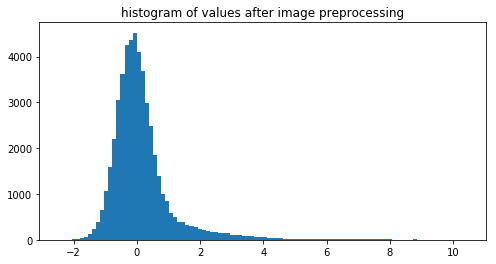

In [13]:
print(x.min(), x.max())
print(x[0:5,0:5])

plt.figure(figsize=(8,4))
plt.title('histogram of values after image preprocessing')
plt.hist(x.reshape(-1), bins=100)

1

### Load pretrained networks

In [14]:
vgg16 = VGG16(weights='imagenet',include_top=True,input_shape=(224,224,3))
r50 = ResNet50(weights='imagenet',include_top=False,input_shape=(224,224,3))

### Read metadata file

In [15]:
df =  pd.read_fwf('metaData.dat', comment = '#')
df.columns = df.iloc[9,:].values
df = df[10:]
df.head()

,SDSS_ID,RA,DEC,D25,redshi,logMst,err_l,GalSize_kpc,D_Mpc,d_pix_kpc
10,1237662635825954925,210.95489999999998,12.64455,0.33113110693986714,0.1029,-99.0,-99.0,42.47806067869379,440.99999325616017,0.8552113203991983
11,1237652947452297303,0.84015,-9.98328,0.5248074948227709,0.0767,11.312,0.016,50.181626715917524,328.7142940929958,0.6374607478101917
12,1237652899137912944,1.0026,-11.17802,0.6165950323262803,0.0383,9.708,0.071,29.440699795795908,164.1428577048438,0.3183148122868964
13,1237661433779716229,211.48905000000002,43.88251,0.7585775667003197,0.0337,9.26,0.062,31.869792393005813,144.4285735487938,0.28008379359836033
14,1237652944786555077,1.48395,16.13445,0.3388441338170015,0.0909,10.7,0.04,38.39840364463448,389.571413397789,0.7554782039377076


In [16]:
df['RA'] = df['RA'].apply(np.float64)
df['DEC'] = df['DEC'].apply(np.float64)
df['D25'] = df['D25'].apply(np.float64)
df['redshi'] = df['redshi'].apply(np.float64)
df['logMstar'] = df['logMst'].apply(np.float64) #renamed
df['err_logMstar'] = df['err_l'].apply(np.float64) #renamed
df['GalSize_kpc'] = df['GalSize_kpc'].apply(np.float64)
df['Distance'] = df['D_Mpc'].apply(np.float64) #renamed
df['d_pix_kpc'] = df['d_pix_kpc'].apply(np.float64)

df['lin_mass'] = np.power(10, df.logMstar)
df['lin_err'] = df['lin_mass'] * np.log(10) * df.err_logMstar

df = df.drop(['logMst','err_l'], axis=1)
df.describe()

,RA,DEC,D25,redshi,GalSize_kpc,d_pix_kpc,logMstar,err_logMstar,Distance,lin_mass,lin_err
count,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,1.877420e+05,1.877420e+05
mean,184.527190,24.898677,0.445798,0.074652,38.318105,0.620438,9.081941,-1.313631,319.936358,7.877701e+10,4.648110e+09
std,61.620064,19.374103,0.168006,0.040143,18.942158,0.333632,12.706553,11.469736,172.041273,9.461819e+10,5.529011e+09
min,0.008250,-11.252830,0.316228,0.010000,4.034125,0.083111,-99.000000,-99.000000,42.857142,1.000000e-99,-2.279559e-97
25%,152.349938,8.662358,0.346737,0.044100,25.157782,0.366519,10.191000,0.021000,189.000006,1.552387e+10,1.144774e+09
50%,185.824575,23.197910,0.389045,0.069000,35.525868,0.573465,10.693000,0.029000,295.714278,4.931738e+10,2.906879e+09
75%,222.151537,39.835143,0.478630,0.096400,48.283920,0.801189,11.032000,0.041000,413.142858,1.076465e+11,6.027530e+09
max,359.994900,70.133250,10.964781,0.299600,1373.931687,2.490003,12.326000,0.800000,1284.000022,2.118361e+12,1.727792e+11


In [17]:
# df.SDSS_ID[:20].apply(lambda x: x)
df['hasFile'] = df.SDSS_ID.apply(lambda x: os.path.isfile(dataFolder+x+'.npy'))

print("data file present:", len(df[df['hasFile']==True]))
print("data file missing:", len(df[df['hasFile']==False]))

data file present: 80306
data file missing: 107436


### Filter images that have no known mass, no actual image, or with an unknown error

In [18]:
df = df[df.logMstar != -99]
df = df[df.hasFile == True]
df = df[df['lin_err']!=0]
df.describe()

,RA,DEC,D25,redshi,GalSize_kpc,d_pix_kpc,logMstar,err_logMstar,Distance,lin_mass,lin_err
count,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,7.885100e+04,7.885100e+04
mean,185.303775,25.672447,0.557644,0.058701,38.101843,0.487867,10.558197,0.031070,251.574576,7.898269e+10,4.398954e+09
std,57.111612,18.944782,0.194465,0.032567,19.838329,0.270663,0.654456,0.016953,139.570856,9.624108e+10,5.552716e+09
min,0.009450,-11.238420,0.407380,0.010000,5.248929,0.083111,7.376000,0.001000,42.857142,2.376840e+07,4.756699e+05
25%,154.486425,9.795145,0.436516,0.033800,24.390653,0.280915,10.200000,0.019000,144.857136,1.584893e+10,1.023221e+09
50%,186.753000,24.400580,0.489779,0.052300,35.043089,0.434670,10.692000,0.028000,224.142852,4.920395e+10,2.693666e+09
75%,221.979375,40.093400,0.602560,0.075600,47.500516,0.628319,11.030000,0.039000,323.999992,1.071519e+11,5.603185e+09
max,359.994900,70.133250,10.964781,0.294800,1373.931687,2.450110,12.326000,0.778000,1263.428628,2.118361e+12,1.414535e+11


In [19]:
random.seed(42)

df = df.sample(frac=1).reset_index(drop=True)

In [20]:
df.head()

,SDSS_ID,RA,DEC,D25,redshi,GalSize_kpc,D_Mpc,d_pix_kpc,logMstar,err_logMstar,Distance,lin_mass,lin_err,hasFile
0,1237648721253957885,232.98435,-0.04219,0.436516,0.1353,73.628694,579.8571237495968,1.124491,11.186,0.022,579.857124,1.534617e+11,7.773890e+09,True
1,1237658801497899152,172.27530,54.09419,0.436516,0.0705,38.365286,302.14286276272367,0.585932,11.044,0.022,302.142863,1.106624e+11,5.605810e+09,True
2,1237678602386014376,16.90380,17.96906,0.407380,0.0756,38.394687,323.9999924387251,0.628319,10.796,0.034,323.999992,6.251727e+10,4.894345e+09,True
3,1237671261739942137,143.39220,13.57625,0.467735,0.0863,50.322261,369.85714520726884,0.717247,11.065,0.019,369.857145,1.161449e+11,5.081235e+09,True
4,1237661387617141036,246.39915,37.24876,0.512861,0.0767,49.039348,328.7142940929958,0.637461,10.820,0.038,328.714294,6.606934e+10,5.780951e+09,True


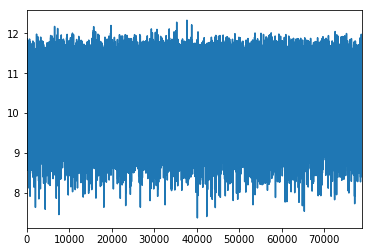

In [21]:
df.logMstar.plot()

In [22]:
print(len(df.SDSS_ID.values))

78851


# Iteration parameters defined here:

- N is the number of galaxies to use for this run
- M is the number of galaxies to train set (rest is holdout)
- chunkSize is the number of galaxies to evaluate at once
- prefixThisRound is the model name, for serialization purposes

In [23]:
N = int(len(df.SDSS_ID.values))
M = int(N*.9)
prefixThisRound = 'sp'
for i in runNameParams:
    prefixThisRound = prefixThisRound + '-' + i

chunkSize = 200
nSplits = 3

# N = 3000 # number of galaxies to take into consideration
# M = 2000 # train vs holdout


# N = int(N*0.01)
# M = int(M*0.01)


In [24]:
ids = df.SDSS_ID.values[:N]
Y = df.logMstar.values[:N]
err = df.err_logMstar.values[:N]
Y_lin = df.lin_mass.values[:N]
err_lin = df.lin_err.values[:N]

In [25]:
print(N)
print(M)
print(chunkSize)
print(prefixThisRound)

78851
70965
200
sp-newSource-ReadLog1pNormCrop.75


In [26]:
# crap instruction to make the auto execution stop here :p

### call img_preproc on all images, per batches of "chunkSize"
### Generate features based on the preprocessed images, pretrained networks and flux densities

In [27]:
def chunkFileName(chunkSize, prefix, chunkNumber):
    fileName = 'Xg3-'+str(chunkSize)+'-'+prefix+'-chunk-' + str(chunkNumber) + '.npy'
    return fileName

In [28]:
prefixThisRound = prefixThisRound + '-model6'

In [29]:
lgbm_params = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l2',
    'nthread': 4,
    #'silent': True,
    'num_leaves': 2**4,
    'learning_rate': 0.01,
    'max_depth': 10,
    'max_bin': 255,
    #'subsample_for_bin': 50000,
    #'subsample': 0.8,
    #'subsample_freq': 1,
    #'colsample_bytree': 0.8,
    #'reg_alpha': 1,
    #'reg_lambda': 0,
    #'min_split_gain': 0.5,
    #'min_child_weight': 1,
    #'min_child_samples': 60,
    #'scale_pos_weight': 1,
    'device' : 'gpu',
    'metric' : 'rmse',
    #'metric' : 'multi_error',
    'verbose':0,          
}

In [30]:
def getFeatures(preProcessingNum):
    Xg3r50 = []
    Xg3vgg16 = []
    postImgFeatures = []
    csize=2
    preImgFeatures = []

    maxChunkNumber = math.ceil(len(ids)/chunkSize)
    chunkStart = 0
    # for chunkStart in tqdm(range(0, 3)):
    for chunkStart in tqdm(range(0, len(ids), chunkSize)):
        curChunk = int((chunkStart//chunkSize))
        valuesInThisChunk = min(chunkStart+chunkSize,len(ids))-chunkStart

        Xg_ = []
        pre_ex_ = []

        # preprocess the image and collect some raw image stats
        for i in range(chunkStart, chunkStart+valuesInThisChunk):
            X = read_image(ids[i])
            Xg_.append(img_preprocnoread(X, preProcessingNum))
            pre_ex_.append([
                X.sum(),
                X.min(),
                X.max(),
                X.mean(),
                X.std(),
                X[X.shape[0]//2,X.shape[1]//2],
                np.mean(X[X.shape[0]//2-csize:X.shape[0]//2+csize,X.shape[1]//2-csize:X.shape[1]//2+csize]), # mean center
                X.shape[0], 
            ])

        # reformat the postprocessing
        pre_ex = np.stack(pre_ex_)
        Xg = np.stack(Xg_)

        # collect some post processing stats
        post_ex = np.hstack([
            np.sum(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
            np.min(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
            np.max(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
            np.mean(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
            np.std(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
            Xg[:,112,112].reshape(valuesInThisChunk,1),       # center
            np.mean(Xg[:,112-csize:112+csize,112-csize:112+csize].reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,-1) # mean center
            ])

        Xg3 = np.zeros((valuesInThisChunk,224,224,3))
        Xg3[:,:,:,:] = Xg.reshape(valuesInThisChunk,224,224,1)

        # do r50 prediction
        Xg3r50_ = r50.predict(Xg3).reshape(valuesInThisChunk, 2048)
        Xg3vgg16_ = vgg16.predict(Xg3)


        if chunkStart == 0:
            Xg3r50 = Xg3r50_
            Xg3vgg16 = Xg3vgg16_
            preImgFeatures = pre_ex
            postImgFeatures = post_ex
        else:
            Xg3r50 = np.concatenate([Xg3r50,Xg3r50_], axis=0)
            Xg3vgg16 = np.concatenate([Xg3vgg16,Xg3vgg16_], axis=0)
            preImgFeatures = np.concatenate([preImgFeatures,pre_ex], axis=0)
            postImgFeatures = np.concatenate([postImgFeatures,post_ex], axis=0)

    postImgFeatureNames = ['norm.flux.sum', 'norm.flux.min',
                           'norm.flux.max', 'norm.flux.mean', 
                           'norm.flux.std', 'center.flux', 
                           'aroundCenter.flux']
    preImgFeatureNames = ['pre.flux.sum', 'pre.flux.min', 
                          'pre.flux.max', 'pre.flux.mean',
                          'pre.flux.std', 'pre.center.flux',
                          'pre.aroundCenter.flux', 'width']


    Xg3 = None
    Xg = None
    X = None

    Distance = df.Distance.values[:N].reshape(N,1)

    Xg3f = np.hstack ( ( 
            Xg3r50, 
            Xg3vgg16, 
            Distance,
            1/Distance,
            Distance**2,
            1/(Distance**2),
            Distance**3,
            1/(Distance**3),
            np.log(Distance),
            1/np.log(Distance),
            np.log(Distance**2),
            1/np.log(Distance**2),
            np.log(Distance)**2,
            1/np.log(Distance)**2,
            preImgFeatures,
            postImgFeatures
            ) )

    distanceNames = ['D', '1/D', 'D**2', '1/D**2', 'D**3', '1/D**3', 'log(D)', '1/log(D)', 'log(D**2)', 'log(1/D**2)', 'log(D)**2', '1/log(D)**2' ]

    # extraImgFeatureNames = ['norm.flux.sum', 'norm.flux.min', 'norm.flux.max', 'norm.flux.mean', 'norm.flux.std', 'center.flux', 'aroundCenter.flux']

    Xg3fNames = ( [prefixThisRound+'.r50.' + str(i) for i in range(Xg3r50.shape[1])]
                + [prefixThisRound+'.vgg16.' + str(i) for i in range(Xg3vgg16.shape[1])] 
                + [prefixThisRound+'.'+ n for n in distanceNames]
                + [prefixThisRound+'.'+ n for n in preImgFeatureNames]
                + [prefixThisRound+'.'+ n for n in postImgFeatureNames])

    print(len(Xg3fNames), Xg3f.shape)
    
    return Xg3f, Xg3fNames
    

In [31]:
def getModels(trainSet, YSet):
    kf = KFold(n_splits=nSplits,shuffle=True, random_state=220673)

    cvtrainpreds = np.zeros([len(Xg3f),nSplits])
    models = []
    xis, linxis = [],[]
    counter = 0
    for tix, vix in kf.split(trainSet):
        X_train, X_test = trainSet[tix], trainSet[vix]
        Y_train, Y_test = YSet[tix], YSet[vix]

        lgb_train = lgbm.Dataset(X_train, Y_train)
        lgb_eval = lgbm.Dataset(X_test, Y_test)

        gbm = lgbm.train(lgbm_params,
                           lgb_train,
                           num_boost_round=20000,
                           valid_sets=[lgb_train,lgb_eval],  # eval training data
                           verbose_eval=100,
                           early_stopping_rounds=100
                        )
        models.append(gbm)

        p = gbm.predict(X_test)
        chiSq = xi2(Y_test,p,err[vix])
        linChiSq = xi2(10**Y_test,10**p,err_lin[vix])
        xis.append(chiSq)
        linxis.append(linChiSq)
        print(counter,chiSq,linChiSq)    

        cvtrainpreds[vix,counter] = p
        counter = counter+1
        
    return models, cvtrainpreds, xis, linxis

# models, cvtrainpreds, xis, linxis = getModels(Xg3f[:M], Y[:M])

# print(models, cvtrainpreds)

# print(xis, linxis)


In [32]:
# reloadImagesAndPreprocess = 0

numPreprocessing = 8
ttaPredictions = np.zeros([numPreprocessing,nSplits,N-M])

for curTTA in range(8):
    Xg3f, Xg3fNames = getFeatures(curTTA)
    models, cvtrainpreds, xis, linxis = getModels(Xg3f[:M], Y[:M])

    ppreds = np.zeros([len(models),N-M])
    for i, m in zip(range(len(models)),models):
        mp = m.predict(Xg3f[M:])
        ppreds[i] = mp

    cvpred = ppreds.mean(axis=0)

    print("Iteration : {}".format(curTTA))
    chiSq = xi2(Y[M:],cvpred,err[M:])
    linChiSq = xi2(10**Y[M:],10**cvpred,err_lin[M:])
    print(chiSq)
    print(linChiSq)
        
    ttaPredictions[curTTA] = ppreds
    




100%|██████████| 395/395 [11:09<00:00,  1.52s/it]


3075 (78851, 3075)
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.356514	valid_1's rmse: 0.354764
[200]	training's rmse: 0.258598	valid_1's rmse: 0.259958
[300]	training's rmse: 0.225951	valid_1's rmse: 0.229552
[400]	training's rmse: 0.211316	valid_1's rmse: 0.216831
[500]	training's rmse: 0.20238	valid_1's rmse: 0.209603
[600]	training's rmse: 0.195793	valid_1's rmse: 0.20471
[700]	training's rmse: 0.190659	valid_1's rmse: 0.201161
[800]	training's rmse: 0.186503	valid_1's rmse: 0.198398
[900]	training's rmse: 0.182913	valid_1's rmse: 0.196235
[1000]	training's rmse: 0.179845	valid_1's rmse: 0.194494
[1100]	training's rmse: 0.177149	valid_1's rmse: 0.193127
[1200]	training's rmse: 0.174717	valid_1's rmse: 0.19195
[1300]	training's rmse: 0.172526	valid_1's rmse: 0.190967
[1400]	training's rmse: 0.170548	valid_1's rmse: 0.190263
[1500]	training's rmse: 0.168729	valid_1's rmse: 0.189656
[1600]	training's rmse: 0.166998	valid_1's rmse: 0.189097
[1

[200]	training's rmse: 0.258087	valid_1's rmse: 0.26427
[300]	training's rmse: 0.225429	valid_1's rmse: 0.232395
[400]	training's rmse: 0.210858	valid_1's rmse: 0.218794
[500]	training's rmse: 0.201983	valid_1's rmse: 0.211099
[600]	training's rmse: 0.195481	valid_1's rmse: 0.206035
[700]	training's rmse: 0.190462	valid_1's rmse: 0.202397
[800]	training's rmse: 0.186328	valid_1's rmse: 0.199561
[900]	training's rmse: 0.182783	valid_1's rmse: 0.197373
[1000]	training's rmse: 0.179744	valid_1's rmse: 0.195641
[1100]	training's rmse: 0.177004	valid_1's rmse: 0.194229
[1200]	training's rmse: 0.174587	valid_1's rmse: 0.193149
[1300]	training's rmse: 0.172392	valid_1's rmse: 0.192244
[1400]	training's rmse: 0.170399	valid_1's rmse: 0.191454
[1500]	training's rmse: 0.168551	valid_1's rmse: 0.190789
[1600]	training's rmse: 0.166832	valid_1's rmse: 0.19025
[1700]	training's rmse: 0.1652	valid_1's rmse: 0.189825
[1800]	training's rmse: 0.163652	valid_1's rmse: 0.18942
[1900]	training's rmse: 0.1

[14300]	training's rmse: 0.0842411	valid_1's rmse: 0.181972
[14400]	training's rmse: 0.0838744	valid_1's rmse: 0.181963
[14500]	training's rmse: 0.0835018	valid_1's rmse: 0.181946
[14600]	training's rmse: 0.0831339	valid_1's rmse: 0.181934
[14700]	training's rmse: 0.0827706	valid_1's rmse: 0.181931
[14800]	training's rmse: 0.0824132	valid_1's rmse: 0.181929
[14900]	training's rmse: 0.0820728	valid_1's rmse: 0.181918
[15000]	training's rmse: 0.0817249	valid_1's rmse: 0.181908
[15100]	training's rmse: 0.081377	valid_1's rmse: 0.181897
[15200]	training's rmse: 0.081024	valid_1's rmse: 0.181884
[15300]	training's rmse: 0.080686	valid_1's rmse: 0.181883
[15400]	training's rmse: 0.0803629	valid_1's rmse: 0.181877
[15500]	training's rmse: 0.080017	valid_1's rmse: 0.18187
[15600]	training's rmse: 0.0796953	valid_1's rmse: 0.18186
[15700]	training's rmse: 0.0793579	valid_1's rmse: 0.181852
[15800]	training's rmse: 0.0790124	valid_1's rmse: 0.181839
[15900]	training's rmse: 0.0786779	valid_1's r

[10300]	training's rmse: 0.100715	valid_1's rmse: 0.181452
[10400]	training's rmse: 0.100254	valid_1's rmse: 0.181443
[10500]	training's rmse: 0.0997771	valid_1's rmse: 0.181431
[10600]	training's rmse: 0.0993175	valid_1's rmse: 0.181413
[10700]	training's rmse: 0.0988418	valid_1's rmse: 0.181391
[10800]	training's rmse: 0.0983809	valid_1's rmse: 0.18137
[10900]	training's rmse: 0.0979339	valid_1's rmse: 0.181354
[11000]	training's rmse: 0.0974814	valid_1's rmse: 0.181335
[11100]	training's rmse: 0.0970396	valid_1's rmse: 0.181307
[11200]	training's rmse: 0.0965916	valid_1's rmse: 0.181293
[11300]	training's rmse: 0.096145	valid_1's rmse: 0.18127
[11400]	training's rmse: 0.095712	valid_1's rmse: 0.181251
[11500]	training's rmse: 0.0952757	valid_1's rmse: 0.181225
[11600]	training's rmse: 0.094846	valid_1's rmse: 0.181209
[11700]	training's rmse: 0.094408	valid_1's rmse: 0.181203
[11800]	training's rmse: 0.0939826	valid_1's rmse: 0.181189
[11900]	training's rmse: 0.0935681	valid_1's rms

  0%|          | 0/395 [00:00<?, ?it/s]

Iteration : 0
60.588125427
137.62959524


100%|██████████| 395/395 [11:09<00:00,  1.39s/it]


3075 (78851, 3075)
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.356289	valid_1's rmse: 0.354392
[200]	training's rmse: 0.258328	valid_1's rmse: 0.2597
[300]	training's rmse: 0.226158	valid_1's rmse: 0.22985
[400]	training's rmse: 0.211459	valid_1's rmse: 0.217088
[500]	training's rmse: 0.202451	valid_1's rmse: 0.209729
[600]	training's rmse: 0.195868	valid_1's rmse: 0.20483
[700]	training's rmse: 0.190808	valid_1's rmse: 0.201292
[800]	training's rmse: 0.186667	valid_1's rmse: 0.198586
[900]	training's rmse: 0.183201	valid_1's rmse: 0.196436
[1000]	training's rmse: 0.180264	valid_1's rmse: 0.194766
[1100]	training's rmse: 0.177602	valid_1's rmse: 0.193413
[1200]	training's rmse: 0.175264	valid_1's rmse: 0.192375
[1300]	training's rmse: 0.173106	valid_1's rmse: 0.191526
[1400]	training's rmse: 0.171093	valid_1's rmse: 0.190726
[1500]	training's rmse: 0.169243	valid_1's rmse: 0.190081
[1600]	training's rmse: 0.167501	valid_1's rmse: 0.189523
[17

[1800]	training's rmse: 0.164362	valid_1's rmse: 0.188842
[1900]	training's rmse: 0.162906	valid_1's rmse: 0.188461
[2000]	training's rmse: 0.161524	valid_1's rmse: 0.18813
[2100]	training's rmse: 0.1602	valid_1's rmse: 0.187831
[2200]	training's rmse: 0.158923	valid_1's rmse: 0.187569
[2300]	training's rmse: 0.157679	valid_1's rmse: 0.187297
[2400]	training's rmse: 0.156479	valid_1's rmse: 0.187087
[2500]	training's rmse: 0.155325	valid_1's rmse: 0.186861
[2600]	training's rmse: 0.154189	valid_1's rmse: 0.186644
[2700]	training's rmse: 0.153109	valid_1's rmse: 0.186438
[2800]	training's rmse: 0.152023	valid_1's rmse: 0.186275
[2900]	training's rmse: 0.150966	valid_1's rmse: 0.186119
[3000]	training's rmse: 0.149956	valid_1's rmse: 0.185974
[3100]	training's rmse: 0.148949	valid_1's rmse: 0.185829
[3200]	training's rmse: 0.14795	valid_1's rmse: 0.185679
[3300]	training's rmse: 0.146964	valid_1's rmse: 0.185535
[3400]	training's rmse: 0.145992	valid_1's rmse: 0.185377
[3500]	training's 

[15800]	training's rmse: 0.0789403	valid_1's rmse: 0.180781
[15900]	training's rmse: 0.0785982	valid_1's rmse: 0.180774
[16000]	training's rmse: 0.0782595	valid_1's rmse: 0.180769
Early stopping, best iteration is:
[15984]	training's rmse: 0.0783147	valid_1's rmse: 0.180766
1 77.1114948086 1640.95511343
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.355988	valid_1's rmse: 0.359512
[200]	training's rmse: 0.258523	valid_1's rmse: 0.263722
[300]	training's rmse: 0.226248	valid_1's rmse: 0.232593
[400]	training's rmse: 0.211704	valid_1's rmse: 0.219331
[500]	training's rmse: 0.202867	valid_1's rmse: 0.211699
[600]	training's rmse: 0.196252	valid_1's rmse: 0.206262
[700]	training's rmse: 0.191075	valid_1's rmse: 0.20233
[800]	training's rmse: 0.186871	valid_1's rmse: 0.199427
[900]	training's rmse: 0.183327	valid_1's rmse: 0.197273
[1000]	training's rmse: 0.180271	valid_1's rmse: 0.195594
[1100]	training's rmse: 0.177598	valid_1's rmse: 0.194279
[120

  0%|          | 0/395 [00:00<?, ?it/s]

Iteration : 1
61.5157227771
191.692552598


100%|██████████| 395/395 [11:10<00:00,  1.40s/it]


3075 (78851, 3075)
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.356359	valid_1's rmse: 0.354684
[200]	training's rmse: 0.25802	valid_1's rmse: 0.259518
[300]	training's rmse: 0.225718	valid_1's rmse: 0.229582
[400]	training's rmse: 0.211047	valid_1's rmse: 0.216968
[500]	training's rmse: 0.202075	valid_1's rmse: 0.209825
[600]	training's rmse: 0.195474	valid_1's rmse: 0.204962
[700]	training's rmse: 0.190323	valid_1's rmse: 0.201443
[800]	training's rmse: 0.186158	valid_1's rmse: 0.198737
[900]	training's rmse: 0.182658	valid_1's rmse: 0.196621
[1000]	training's rmse: 0.179608	valid_1's rmse: 0.194965
[1100]	training's rmse: 0.176922	valid_1's rmse: 0.19355
[1200]	training's rmse: 0.174548	valid_1's rmse: 0.192462
[1300]	training's rmse: 0.172389	valid_1's rmse: 0.191596
[1400]	training's rmse: 0.170374	valid_1's rmse: 0.190795
[1500]	training's rmse: 0.168522	valid_1's rmse: 0.190136
[1600]	training's rmse: 0.166788	valid_1's rmse: 0.189524
[

[400]	training's rmse: 0.210975	valid_1's rmse: 0.219194
[500]	training's rmse: 0.20203	valid_1's rmse: 0.211414
[600]	training's rmse: 0.195491	valid_1's rmse: 0.206196
[700]	training's rmse: 0.190405	valid_1's rmse: 0.202438
[800]	training's rmse: 0.186261	valid_1's rmse: 0.199645
[900]	training's rmse: 0.182768	valid_1's rmse: 0.197477
[1000]	training's rmse: 0.179707	valid_1's rmse: 0.19578
[1100]	training's rmse: 0.177015	valid_1's rmse: 0.1944
[1200]	training's rmse: 0.174651	valid_1's rmse: 0.193375
[1300]	training's rmse: 0.172479	valid_1's rmse: 0.192475
[1400]	training's rmse: 0.17051	valid_1's rmse: 0.191773
[1500]	training's rmse: 0.168643	valid_1's rmse: 0.191099
[1600]	training's rmse: 0.166936	valid_1's rmse: 0.190591
[1700]	training's rmse: 0.165335	valid_1's rmse: 0.190128
[1800]	training's rmse: 0.163811	valid_1's rmse: 0.189704
[1900]	training's rmse: 0.162357	valid_1's rmse: 0.189358
[2000]	training's rmse: 0.160985	valid_1's rmse: 0.189076
[2100]	training's rmse: 0

[14500]	training's rmse: 0.0835402	valid_1's rmse: 0.181961
[14600]	training's rmse: 0.0831826	valid_1's rmse: 0.181953
[14700]	training's rmse: 0.0828209	valid_1's rmse: 0.181948
[14800]	training's rmse: 0.0824735	valid_1's rmse: 0.181939
[14900]	training's rmse: 0.0821275	valid_1's rmse: 0.18193
[15000]	training's rmse: 0.0817735	valid_1's rmse: 0.181924
[15100]	training's rmse: 0.0814239	valid_1's rmse: 0.181916
[15200]	training's rmse: 0.0810849	valid_1's rmse: 0.181904
[15300]	training's rmse: 0.0807255	valid_1's rmse: 0.181898
[15400]	training's rmse: 0.0803801	valid_1's rmse: 0.181895
[15500]	training's rmse: 0.0800329	valid_1's rmse: 0.18188
[15600]	training's rmse: 0.0796917	valid_1's rmse: 0.181873
[15700]	training's rmse: 0.0793679	valid_1's rmse: 0.181865
[15800]	training's rmse: 0.0790314	valid_1's rmse: 0.181853
[15900]	training's rmse: 0.0786945	valid_1's rmse: 0.181838
[16000]	training's rmse: 0.0783544	valid_1's rmse: 0.181823
[16100]	training's rmse: 0.0780187	valid_1

[10200]	training's rmse: 0.101376	valid_1's rmse: 0.18112
[10300]	training's rmse: 0.100907	valid_1's rmse: 0.181103
[10400]	training's rmse: 0.100444	valid_1's rmse: 0.181082
[10500]	training's rmse: 0.0999699	valid_1's rmse: 0.181058
[10600]	training's rmse: 0.0994948	valid_1's rmse: 0.181024
[10700]	training's rmse: 0.099027	valid_1's rmse: 0.181003
[10800]	training's rmse: 0.0985815	valid_1's rmse: 0.180989
[10900]	training's rmse: 0.0981196	valid_1's rmse: 0.180969
[11000]	training's rmse: 0.0976657	valid_1's rmse: 0.180942
[11100]	training's rmse: 0.0972124	valid_1's rmse: 0.180922
[11200]	training's rmse: 0.0967652	valid_1's rmse: 0.180901
[11300]	training's rmse: 0.0963183	valid_1's rmse: 0.180882
[11400]	training's rmse: 0.0958688	valid_1's rmse: 0.180848
[11500]	training's rmse: 0.0954376	valid_1's rmse: 0.180826
[11600]	training's rmse: 0.0949875	valid_1's rmse: 0.180808
[11700]	training's rmse: 0.0945458	valid_1's rmse: 0.180786
[11800]	training's rmse: 0.0941215	valid_1's 

  0%|          | 0/395 [00:00<?, ?it/s]

Iteration : 2
59.8449209221
140.153554485


100%|██████████| 395/395 [11:10<00:00,  1.39s/it]


3075 (78851, 3075)
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.356052	valid_1's rmse: 0.354379
[200]	training's rmse: 0.258416	valid_1's rmse: 0.259987
[300]	training's rmse: 0.225732	valid_1's rmse: 0.229645
[400]	training's rmse: 0.211141	valid_1's rmse: 0.217041
[500]	training's rmse: 0.202199	valid_1's rmse: 0.209835
[600]	training's rmse: 0.195629	valid_1's rmse: 0.204934
[700]	training's rmse: 0.190568	valid_1's rmse: 0.201415
[800]	training's rmse: 0.186435	valid_1's rmse: 0.198781
[900]	training's rmse: 0.182981	valid_1's rmse: 0.196752
[1000]	training's rmse: 0.18	valid_1's rmse: 0.195125
[1100]	training's rmse: 0.177345	valid_1's rmse: 0.193875
[1200]	training's rmse: 0.174929	valid_1's rmse: 0.192856
[1300]	training's rmse: 0.172757	valid_1's rmse: 0.192015
[1400]	training's rmse: 0.170776	valid_1's rmse: 0.191273
[1500]	training's rmse: 0.168932	valid_1's rmse: 0.190702
[1600]	training's rmse: 0.167199	valid_1's rmse: 0.19014
[170

[200]	training's rmse: 0.257888	valid_1's rmse: 0.264014
[300]	training's rmse: 0.225697	valid_1's rmse: 0.232619
[400]	training's rmse: 0.210963	valid_1's rmse: 0.21898
[500]	training's rmse: 0.202066	valid_1's rmse: 0.211173
[600]	training's rmse: 0.195555	valid_1's rmse: 0.20596
[700]	training's rmse: 0.190441	valid_1's rmse: 0.202125
[800]	training's rmse: 0.186338	valid_1's rmse: 0.199276
[900]	training's rmse: 0.182907	valid_1's rmse: 0.197106
[1000]	training's rmse: 0.179946	valid_1's rmse: 0.19542
[1100]	training's rmse: 0.177311	valid_1's rmse: 0.194077
[1200]	training's rmse: 0.17491	valid_1's rmse: 0.192992
[1300]	training's rmse: 0.172781	valid_1's rmse: 0.192087
[1400]	training's rmse: 0.170822	valid_1's rmse: 0.191335
[1500]	training's rmse: 0.16898	valid_1's rmse: 0.190732
[1600]	training's rmse: 0.167245	valid_1's rmse: 0.190165
[1700]	training's rmse: 0.165627	valid_1's rmse: 0.189713
[1800]	training's rmse: 0.164094	valid_1's rmse: 0.189314
[1900]	training's rmse: 0.1

[14300]	training's rmse: 0.0836114	valid_1's rmse: 0.181544
[14400]	training's rmse: 0.0832546	valid_1's rmse: 0.181527
[14500]	training's rmse: 0.082902	valid_1's rmse: 0.181514
[14600]	training's rmse: 0.0825314	valid_1's rmse: 0.181497
[14700]	training's rmse: 0.0821645	valid_1's rmse: 0.181477
[14800]	training's rmse: 0.0818162	valid_1's rmse: 0.181465
[14900]	training's rmse: 0.0814573	valid_1's rmse: 0.181454
[15000]	training's rmse: 0.0811067	valid_1's rmse: 0.181442
[15100]	training's rmse: 0.080758	valid_1's rmse: 0.181423
[15200]	training's rmse: 0.0804166	valid_1's rmse: 0.18142
[15300]	training's rmse: 0.0800781	valid_1's rmse: 0.181409
[15400]	training's rmse: 0.0797376	valid_1's rmse: 0.181399
[15500]	training's rmse: 0.0793947	valid_1's rmse: 0.181387
[15600]	training's rmse: 0.0790572	valid_1's rmse: 0.181379
[15700]	training's rmse: 0.0787115	valid_1's rmse: 0.181366
[15800]	training's rmse: 0.0783825	valid_1's rmse: 0.181348
[15900]	training's rmse: 0.0780654	valid_1'

[9100]	training's rmse: 0.106746	valid_1's rmse: 0.181707
[9200]	training's rmse: 0.10625	valid_1's rmse: 0.181693
[9300]	training's rmse: 0.105734	valid_1's rmse: 0.181661
[9400]	training's rmse: 0.105223	valid_1's rmse: 0.181624
[9500]	training's rmse: 0.104711	valid_1's rmse: 0.181609
[9600]	training's rmse: 0.104226	valid_1's rmse: 0.181592
[9700]	training's rmse: 0.103736	valid_1's rmse: 0.181579
[9800]	training's rmse: 0.103241	valid_1's rmse: 0.181553
[9900]	training's rmse: 0.102763	valid_1's rmse: 0.181517
[10000]	training's rmse: 0.102285	valid_1's rmse: 0.181492
[10100]	training's rmse: 0.101812	valid_1's rmse: 0.181462
[10200]	training's rmse: 0.101349	valid_1's rmse: 0.181444
[10300]	training's rmse: 0.10088	valid_1's rmse: 0.18142
[10400]	training's rmse: 0.100418	valid_1's rmse: 0.181395
[10500]	training's rmse: 0.0999506	valid_1's rmse: 0.18138
[10600]	training's rmse: 0.0994969	valid_1's rmse: 0.181356
[10700]	training's rmse: 0.0990484	valid_1's rmse: 0.181332
[10800]

  0%|          | 0/395 [00:00<?, ?it/s]

Iteration : 3
60.329488352
146.330042299


100%|██████████| 395/395 [11:13<00:00,  1.40s/it]


3075 (78851, 3075)
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.356266	valid_1's rmse: 0.354439
[200]	training's rmse: 0.258193	valid_1's rmse: 0.259486
[300]	training's rmse: 0.225943	valid_1's rmse: 0.229512
[400]	training's rmse: 0.211044	valid_1's rmse: 0.216585
[500]	training's rmse: 0.202068	valid_1's rmse: 0.209495
[600]	training's rmse: 0.195551	valid_1's rmse: 0.204744
[700]	training's rmse: 0.190475	valid_1's rmse: 0.201371
[800]	training's rmse: 0.186282	valid_1's rmse: 0.198742
[900]	training's rmse: 0.182705	valid_1's rmse: 0.196696
[1000]	training's rmse: 0.179604	valid_1's rmse: 0.195012
[1100]	training's rmse: 0.176884	valid_1's rmse: 0.193656
[1200]	training's rmse: 0.174458	valid_1's rmse: 0.192602
[1300]	training's rmse: 0.172221	valid_1's rmse: 0.191727
[1400]	training's rmse: 0.170204	valid_1's rmse: 0.191032
[1500]	training's rmse: 0.168344	valid_1's rmse: 0.190389
[1600]	training's rmse: 0.166569	valid_1's rmse: 0.189826

[14100]	training's rmse: 0.0842953	valid_1's rmse: 0.181799
[14200]	training's rmse: 0.0839307	valid_1's rmse: 0.181789
[14300]	training's rmse: 0.0835604	valid_1's rmse: 0.18178
[14400]	training's rmse: 0.0831995	valid_1's rmse: 0.181771
[14500]	training's rmse: 0.0828483	valid_1's rmse: 0.181762
[14600]	training's rmse: 0.0825063	valid_1's rmse: 0.181758
[14700]	training's rmse: 0.0821576	valid_1's rmse: 0.181749
[14800]	training's rmse: 0.0817961	valid_1's rmse: 0.181742
[14900]	training's rmse: 0.081442	valid_1's rmse: 0.181729
[15000]	training's rmse: 0.0810992	valid_1's rmse: 0.18172
[15100]	training's rmse: 0.080749	valid_1's rmse: 0.181715
[15200]	training's rmse: 0.0804126	valid_1's rmse: 0.181705
[15300]	training's rmse: 0.0800722	valid_1's rmse: 0.181697
[15400]	training's rmse: 0.0797339	valid_1's rmse: 0.181692
[15500]	training's rmse: 0.0793959	valid_1's rmse: 0.181685
[15600]	training's rmse: 0.079065	valid_1's rmse: 0.181676
[15700]	training's rmse: 0.0787208	valid_1's 

[11300]	training's rmse: 0.0960406	valid_1's rmse: 0.181529
[11400]	training's rmse: 0.0956128	valid_1's rmse: 0.181526
[11500]	training's rmse: 0.0951655	valid_1's rmse: 0.181511
[11600]	training's rmse: 0.0947379	valid_1's rmse: 0.181492
[11700]	training's rmse: 0.0943172	valid_1's rmse: 0.181479
[11800]	training's rmse: 0.0938895	valid_1's rmse: 0.181459
[11900]	training's rmse: 0.0934617	valid_1's rmse: 0.181444
[12000]	training's rmse: 0.0930553	valid_1's rmse: 0.181429
[12100]	training's rmse: 0.0926528	valid_1's rmse: 0.18142
[12200]	training's rmse: 0.0922343	valid_1's rmse: 0.181401
[12300]	training's rmse: 0.0918253	valid_1's rmse: 0.181382
[12400]	training's rmse: 0.0914135	valid_1's rmse: 0.181364
[12500]	training's rmse: 0.0910123	valid_1's rmse: 0.181348
[12600]	training's rmse: 0.0905994	valid_1's rmse: 0.181334
[12700]	training's rmse: 0.0901971	valid_1's rmse: 0.181313
[12800]	training's rmse: 0.0897998	valid_1's rmse: 0.181291
[12900]	training's rmse: 0.0894124	valid_

[8900]	training's rmse: 0.108184	valid_1's rmse: 0.181899
[9000]	training's rmse: 0.107655	valid_1's rmse: 0.181874
[9100]	training's rmse: 0.107139	valid_1's rmse: 0.181843
[9200]	training's rmse: 0.106643	valid_1's rmse: 0.181825
[9300]	training's rmse: 0.106132	valid_1's rmse: 0.181803
[9400]	training's rmse: 0.105633	valid_1's rmse: 0.181789
[9500]	training's rmse: 0.105148	valid_1's rmse: 0.181771
[9600]	training's rmse: 0.104652	valid_1's rmse: 0.181758
[9700]	training's rmse: 0.104164	valid_1's rmse: 0.181738
[9800]	training's rmse: 0.103669	valid_1's rmse: 0.181713
[9900]	training's rmse: 0.103182	valid_1's rmse: 0.181682
[10000]	training's rmse: 0.102696	valid_1's rmse: 0.181657
[10100]	training's rmse: 0.102215	valid_1's rmse: 0.181629
[10200]	training's rmse: 0.101726	valid_1's rmse: 0.181616
[10300]	training's rmse: 0.101236	valid_1's rmse: 0.181589
[10400]	training's rmse: 0.100763	valid_1's rmse: 0.181567
[10500]	training's rmse: 0.100293	valid_1's rmse: 0.181549
[10600]	

  0%|          | 0/395 [00:00<?, ?it/s]

Iteration : 4
60.0417278383
175.392258539


100%|██████████| 395/395 [11:11<00:00,  1.39s/it]


3075 (78851, 3075)
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.356827	valid_1's rmse: 0.354964
[200]	training's rmse: 0.258875	valid_1's rmse: 0.259867
[300]	training's rmse: 0.226326	valid_1's rmse: 0.229568
[400]	training's rmse: 0.211483	valid_1's rmse: 0.216576
[500]	training's rmse: 0.202434	valid_1's rmse: 0.209355
[600]	training's rmse: 0.195895	valid_1's rmse: 0.204567
[700]	training's rmse: 0.190764	valid_1's rmse: 0.201012
[800]	training's rmse: 0.186611	valid_1's rmse: 0.198382
[900]	training's rmse: 0.183061	valid_1's rmse: 0.196331
[1000]	training's rmse: 0.18	valid_1's rmse: 0.194711
[1100]	training's rmse: 0.177291	valid_1's rmse: 0.193416
[1200]	training's rmse: 0.174861	valid_1's rmse: 0.192347
[1300]	training's rmse: 0.172661	valid_1's rmse: 0.191511
[1400]	training's rmse: 0.170649	valid_1's rmse: 0.190793
[1500]	training's rmse: 0.168775	valid_1's rmse: 0.190224
[1600]	training's rmse: 0.167009	valid_1's rmse: 0.189645
[17

[14100]	training's rmse: 0.0844212	valid_1's rmse: 0.181148
[14200]	training's rmse: 0.0840622	valid_1's rmse: 0.181137
[14300]	training's rmse: 0.0837019	valid_1's rmse: 0.181122
[14400]	training's rmse: 0.0833398	valid_1's rmse: 0.181111
[14500]	training's rmse: 0.0829884	valid_1's rmse: 0.181108
[14600]	training's rmse: 0.0826359	valid_1's rmse: 0.181095
[14700]	training's rmse: 0.0822869	valid_1's rmse: 0.181082
[14800]	training's rmse: 0.081949	valid_1's rmse: 0.181073
[14900]	training's rmse: 0.0816067	valid_1's rmse: 0.181064
[15000]	training's rmse: 0.0812473	valid_1's rmse: 0.181056
[15100]	training's rmse: 0.0809012	valid_1's rmse: 0.181046
[15200]	training's rmse: 0.0805514	valid_1's rmse: 0.181041
[15300]	training's rmse: 0.0802047	valid_1's rmse: 0.181035
[15400]	training's rmse: 0.0798637	valid_1's rmse: 0.181034
[15500]	training's rmse: 0.0795292	valid_1's rmse: 0.181021
[15600]	training's rmse: 0.0791994	valid_1's rmse: 0.181017
[15700]	training's rmse: 0.078865	valid_1

[8200]	training's rmse: 0.111417	valid_1's rmse: 0.182609
[8300]	training's rmse: 0.110869	valid_1's rmse: 0.182562
[8400]	training's rmse: 0.110332	valid_1's rmse: 0.182532
[8500]	training's rmse: 0.109812	valid_1's rmse: 0.182493
[8600]	training's rmse: 0.109278	valid_1's rmse: 0.182461
[8700]	training's rmse: 0.108756	valid_1's rmse: 0.182431
[8800]	training's rmse: 0.10824	valid_1's rmse: 0.182404
[8900]	training's rmse: 0.10771	valid_1's rmse: 0.182376
[9000]	training's rmse: 0.107196	valid_1's rmse: 0.182353
[9100]	training's rmse: 0.10668	valid_1's rmse: 0.182322
[9200]	training's rmse: 0.106169	valid_1's rmse: 0.182298
[9300]	training's rmse: 0.105683	valid_1's rmse: 0.182267
[9400]	training's rmse: 0.105199	valid_1's rmse: 0.182241
[9500]	training's rmse: 0.104704	valid_1's rmse: 0.182221
[9600]	training's rmse: 0.104196	valid_1's rmse: 0.1822
[9700]	training's rmse: 0.103706	valid_1's rmse: 0.182179
[9800]	training's rmse: 0.103231	valid_1's rmse: 0.182157
[9900]	training's r

[7000]	training's rmse: 0.118855	valid_1's rmse: 0.182384
[7100]	training's rmse: 0.118238	valid_1's rmse: 0.182342
[7200]	training's rmse: 0.117622	valid_1's rmse: 0.182311
[7300]	training's rmse: 0.117027	valid_1's rmse: 0.182269
[7400]	training's rmse: 0.116423	valid_1's rmse: 0.182238
[7500]	training's rmse: 0.115857	valid_1's rmse: 0.182205
[7600]	training's rmse: 0.115253	valid_1's rmse: 0.182169
[7700]	training's rmse: 0.114677	valid_1's rmse: 0.18213
[7800]	training's rmse: 0.114092	valid_1's rmse: 0.182116
[7900]	training's rmse: 0.113517	valid_1's rmse: 0.182077
[8000]	training's rmse: 0.112971	valid_1's rmse: 0.182049
[8100]	training's rmse: 0.112414	valid_1's rmse: 0.182018
[8200]	training's rmse: 0.111872	valid_1's rmse: 0.181984
[8300]	training's rmse: 0.111332	valid_1's rmse: 0.181967
[8400]	training's rmse: 0.110783	valid_1's rmse: 0.181934
[8500]	training's rmse: 0.11025	valid_1's rmse: 0.181914
[8600]	training's rmse: 0.109704	valid_1's rmse: 0.181888
[8700]	training'

  0%|          | 0/395 [00:00<?, ?it/s]

Iteration : 5
59.9002970579
186.845310706


100%|██████████| 395/395 [11:13<00:00,  1.40s/it]


3075 (78851, 3075)
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.356272	valid_1's rmse: 0.354344
[200]	training's rmse: 0.258493	valid_1's rmse: 0.259571
[300]	training's rmse: 0.225983	valid_1's rmse: 0.229462
[400]	training's rmse: 0.211071	valid_1's rmse: 0.21654
[500]	training's rmse: 0.202078	valid_1's rmse: 0.209274
[600]	training's rmse: 0.195497	valid_1's rmse: 0.204314
[700]	training's rmse: 0.190442	valid_1's rmse: 0.200909
[800]	training's rmse: 0.186271	valid_1's rmse: 0.198352
[900]	training's rmse: 0.182763	valid_1's rmse: 0.196289
[1000]	training's rmse: 0.179707	valid_1's rmse: 0.194683
[1100]	training's rmse: 0.176996	valid_1's rmse: 0.193288
[1200]	training's rmse: 0.17458	valid_1's rmse: 0.192212
[1300]	training's rmse: 0.172412	valid_1's rmse: 0.191349
[1400]	training's rmse: 0.170395	valid_1's rmse: 0.190607
[1500]	training's rmse: 0.168529	valid_1's rmse: 0.189948
[1600]	training's rmse: 0.166777	valid_1's rmse: 0.189428
[

[14100]	training's rmse: 0.0845224	valid_1's rmse: 0.180818
[14200]	training's rmse: 0.0841548	valid_1's rmse: 0.180811
Early stopping, best iteration is:
[14166]	training's rmse: 0.0842745	valid_1's rmse: 0.180805
0 80.3454658941 134.716123047
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.355424	valid_1's rmse: 0.360351
[200]	training's rmse: 0.258056	valid_1's rmse: 0.26344
[300]	training's rmse: 0.22605	valid_1's rmse: 0.232268
[400]	training's rmse: 0.2111	valid_1's rmse: 0.218395
[500]	training's rmse: 0.202224	valid_1's rmse: 0.210719
[600]	training's rmse: 0.195706	valid_1's rmse: 0.2055
[700]	training's rmse: 0.190614	valid_1's rmse: 0.20177
[800]	training's rmse: 0.186377	valid_1's rmse: 0.198934
[900]	training's rmse: 0.182846	valid_1's rmse: 0.196783
[1000]	training's rmse: 0.179796	valid_1's rmse: 0.195059
[1100]	training's rmse: 0.177147	valid_1's rmse: 0.193678
[1200]	training's rmse: 0.174755	valid_1's rmse: 0.192578
[1300]	train

[13700]	training's rmse: 0.0865997	valid_1's rmse: 0.18137
[13800]	training's rmse: 0.0862217	valid_1's rmse: 0.181362
[13900]	training's rmse: 0.0858488	valid_1's rmse: 0.181355
[14000]	training's rmse: 0.0854783	valid_1's rmse: 0.18135
[14100]	training's rmse: 0.0851049	valid_1's rmse: 0.181349
[14200]	training's rmse: 0.0847334	valid_1's rmse: 0.181334
[14300]	training's rmse: 0.0843718	valid_1's rmse: 0.181329
[14400]	training's rmse: 0.0840192	valid_1's rmse: 0.181324
[14500]	training's rmse: 0.0836626	valid_1's rmse: 0.181315
[14600]	training's rmse: 0.0832981	valid_1's rmse: 0.181309
[14700]	training's rmse: 0.0829346	valid_1's rmse: 0.181295
[14800]	training's rmse: 0.0825823	valid_1's rmse: 0.181277
[14900]	training's rmse: 0.0822381	valid_1's rmse: 0.181267
[15000]	training's rmse: 0.0818965	valid_1's rmse: 0.181261
[15100]	training's rmse: 0.0815427	valid_1's rmse: 0.181255
[15200]	training's rmse: 0.0811975	valid_1's rmse: 0.181244
[15300]	training's rmse: 0.0808579	valid_1

[10000]	training's rmse: 0.102574	valid_1's rmse: 0.181641
[10100]	training's rmse: 0.102103	valid_1's rmse: 0.181611
[10200]	training's rmse: 0.101626	valid_1's rmse: 0.181593
[10300]	training's rmse: 0.10116	valid_1's rmse: 0.181575
[10400]	training's rmse: 0.100706	valid_1's rmse: 0.181556
[10500]	training's rmse: 0.100248	valid_1's rmse: 0.181532
[10600]	training's rmse: 0.0997889	valid_1's rmse: 0.181512
[10700]	training's rmse: 0.0993238	valid_1's rmse: 0.181495
[10800]	training's rmse: 0.0988736	valid_1's rmse: 0.181471
[10900]	training's rmse: 0.0984225	valid_1's rmse: 0.18146
[11000]	training's rmse: 0.0979706	valid_1's rmse: 0.181433
[11100]	training's rmse: 0.0975283	valid_1's rmse: 0.181416
[11200]	training's rmse: 0.097072	valid_1's rmse: 0.181389
[11300]	training's rmse: 0.0966418	valid_1's rmse: 0.181377
[11400]	training's rmse: 0.0962116	valid_1's rmse: 0.181354
[11500]	training's rmse: 0.0957733	valid_1's rmse: 0.181341
[11600]	training's rmse: 0.0953482	valid_1's rmse

  0%|          | 0/395 [00:00<?, ?it/s]

Iteration : 6
60.5063751466
147.028554936


100%|██████████| 395/395 [11:12<00:00,  1.39s/it]


3075 (78851, 3075)
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.356301	valid_1's rmse: 0.354681
[200]	training's rmse: 0.258305	valid_1's rmse: 0.259727
[300]	training's rmse: 0.225932	valid_1's rmse: 0.229302
[400]	training's rmse: 0.211144	valid_1's rmse: 0.216427
[500]	training's rmse: 0.202214	valid_1's rmse: 0.209212
[600]	training's rmse: 0.19566	valid_1's rmse: 0.204303
[700]	training's rmse: 0.190618	valid_1's rmse: 0.200802
[800]	training's rmse: 0.186517	valid_1's rmse: 0.198165
[900]	training's rmse: 0.182987	valid_1's rmse: 0.196083
[1000]	training's rmse: 0.179952	valid_1's rmse: 0.194388
[1100]	training's rmse: 0.177295	valid_1's rmse: 0.193122
[1200]	training's rmse: 0.174889	valid_1's rmse: 0.192082
[1300]	training's rmse: 0.172704	valid_1's rmse: 0.191194
[1400]	training's rmse: 0.170709	valid_1's rmse: 0.190503
[1500]	training's rmse: 0.168844	valid_1's rmse: 0.189853
[1600]	training's rmse: 0.167107	valid_1's rmse: 0.189322


[700]	training's rmse: 0.190575	valid_1's rmse: 0.201865
[800]	training's rmse: 0.186397	valid_1's rmse: 0.199099
[900]	training's rmse: 0.182913	valid_1's rmse: 0.196967
[1000]	training's rmse: 0.179876	valid_1's rmse: 0.19529
[1100]	training's rmse: 0.177204	valid_1's rmse: 0.193903
[1200]	training's rmse: 0.174817	valid_1's rmse: 0.192757
[1300]	training's rmse: 0.172641	valid_1's rmse: 0.191746
[1400]	training's rmse: 0.170677	valid_1's rmse: 0.190955
[1500]	training's rmse: 0.16881	valid_1's rmse: 0.190279
[1600]	training's rmse: 0.167072	valid_1's rmse: 0.189692
[1700]	training's rmse: 0.165449	valid_1's rmse: 0.189189
[1800]	training's rmse: 0.163919	valid_1's rmse: 0.188771
[1900]	training's rmse: 0.162512	valid_1's rmse: 0.188393
[2000]	training's rmse: 0.161129	valid_1's rmse: 0.188033
[2100]	training's rmse: 0.159801	valid_1's rmse: 0.18776
[2200]	training's rmse: 0.158545	valid_1's rmse: 0.187487
[2300]	training's rmse: 0.157313	valid_1's rmse: 0.187242
[2400]	training's rm

[14800]	training's rmse: 0.082874	valid_1's rmse: 0.181143
[14900]	training's rmse: 0.0825218	valid_1's rmse: 0.181134
[15000]	training's rmse: 0.0821552	valid_1's rmse: 0.181116
[15100]	training's rmse: 0.0818006	valid_1's rmse: 0.181111
[15200]	training's rmse: 0.0814498	valid_1's rmse: 0.181096
[15300]	training's rmse: 0.0810945	valid_1's rmse: 0.18108
[15400]	training's rmse: 0.0807513	valid_1's rmse: 0.181065
[15500]	training's rmse: 0.0804191	valid_1's rmse: 0.181057
[15600]	training's rmse: 0.0800768	valid_1's rmse: 0.181045
[15700]	training's rmse: 0.0797437	valid_1's rmse: 0.181033
[15800]	training's rmse: 0.079397	valid_1's rmse: 0.181021
[15900]	training's rmse: 0.0790705	valid_1's rmse: 0.181007
[16000]	training's rmse: 0.0787398	valid_1's rmse: 0.180995
[16100]	training's rmse: 0.0784094	valid_1's rmse: 0.180986
[16200]	training's rmse: 0.0780756	valid_1's rmse: 0.180974
[16300]	training's rmse: 0.0777568	valid_1's rmse: 0.180975
Early stopping, best iteration is:
[16213]	

[12300]	training's rmse: 0.0918229	valid_1's rmse: 0.181298
[12400]	training's rmse: 0.0914249	valid_1's rmse: 0.181285
[12500]	training's rmse: 0.0910178	valid_1's rmse: 0.181273
[12600]	training's rmse: 0.0906071	valid_1's rmse: 0.181259
[12700]	training's rmse: 0.0902135	valid_1's rmse: 0.181238
[12800]	training's rmse: 0.0898119	valid_1's rmse: 0.181221
[12900]	training's rmse: 0.08942	valid_1's rmse: 0.181213
[13000]	training's rmse: 0.0890186	valid_1's rmse: 0.181203
[13100]	training's rmse: 0.0886416	valid_1's rmse: 0.18119
[13200]	training's rmse: 0.0882393	valid_1's rmse: 0.181166
[13300]	training's rmse: 0.0878511	valid_1's rmse: 0.18115
[13400]	training's rmse: 0.0874504	valid_1's rmse: 0.181136
[13500]	training's rmse: 0.0870678	valid_1's rmse: 0.181118
[13600]	training's rmse: 0.0866832	valid_1's rmse: 0.181105
[13700]	training's rmse: 0.0862959	valid_1's rmse: 0.181086
[13800]	training's rmse: 0.0859205	valid_1's rmse: 0.181073
[13900]	training's rmse: 0.0855493	valid_1's

In [33]:
print(ttaPredictions.shape)
print(ttaPredictions[:,:,0])

(8, 3, 7886)
[[ 10.74889786  10.75988952  10.75947786]
 [ 10.68916076  10.71162126  10.69799881]
 [ 10.75648516  10.76126428  10.74767171]
 [ 10.74892393  10.69078245  10.7360299 ]
 [ 10.71231419  10.70881036  10.7239366 ]
 [ 10.72693501  10.74375724  10.74594588]
 [ 10.75396913  10.72601924  10.75285038]
 [ 10.75230014  10.74323709  10.74048101]]


In [34]:
cvpred = ttaPredictions.mean(axis=0).mean(axis=0)

print("Iterations : {}".format(nSplits*(curTTA+1)))
chiSq = xi2(Y[M:],cvpred,err[M:])
linChiSq = xi2(10**Y[M:],10**cvpred,err_lin[M:])
print(chiSq)
print(linChiSq)

# ttaPredictions[curTTA] = ppreds


Iterations : 24
57.2063131605
150.61448157


In [46]:
for i in range(ttaPredictions.shape[0]):
    cvpred = ttaPredictions[i].mean(axis=0)
    chiSq = xi2(Y[M:],cvpred,err[M:])
    linChiSq = xi2(10**Y[M:],10**cvpred,err_lin[M:])
    print("Iteration {}: x²:{:2f} lin x²:{:2f} [".format(i,chiSq,linChiSq), end='')
    
    for j in range(ttaPredictions.shape[1]):
        cvpred = ttaPredictions[i,j]
        chiSq = xi2(Y[M:],cvpred,err[M:])
        linChiSq = xi2(10**Y[M:],10**cvpred,err_lin[M:])
        print("{:2f} {:2f} ".format(chiSq, linChiSq), end='')
        
    print("]")


Iteration 0: x²:60.588125 lin x²:137.629595 [64.039406 144.898139 62.708936 141.106599 62.895182 139.109267 ]
Iteration 1: x²:61.515723 lin x²:191.692553 [64.418611 194.725494 61.894836 191.105178 65.623192 199.953488 ]
Iteration 2: x²:59.844921 lin x²:140.153554 [63.481772 145.833588 61.750386 152.086850 62.545139 140.719047 ]
Iteration 3: x²:60.329488 lin x²:146.330042 [63.639371 140.982973 63.348567 159.867566 62.602334 157.054926 ]
Iteration 4: x²:60.041728 lin x²:175.392259 [62.796371 155.328960 63.462293 227.907252 62.226022 177.527529 ]
Iteration 5: x²:59.900297 lin x²:186.845311 [61.822557 196.103650 66.196268 176.200304 61.694322 208.033308 ]
Iteration 6: x²:60.506375 lin x²:147.028555 [63.711979 144.312326 62.903211 167.537073 62.735615 145.420870 ]
Iteration 7: x²:60.877361 lin x²:148.138649 [63.361428 163.313007 66.902758 150.695359 62.175337 149.908300 ]


In [47]:
cvpred = ttaPredictions.mean(axis=0).mean(axis=0)

chiSq = xi2(Y[M:],cvpred,err[M:])
linChiSq = xi2(10**Y[M:],10**cvpred,err_lin[M:])
print("Values over all {} iterations : {},  {}".format(nSplits*(curTTA+1), chiSq, linChiSq))


Values over all 24 iterations : 57.206313160518896,  150.6144815704485


In [35]:
# print(ttaPredictions.mean(0).mean(0)[3])
# print(ttaPredictions[:,:,3])

In [36]:
diehere

NameError: name 'diehere' is not defined

In [ ]:
plt.imshow(img_preproc('1237662637444694216',0))
plt.figure()
plt.imshow(img_preproc('1237662637444694216',1))
plt.figure()
plt.imshow(img_preproc('1237662637444694216',2))
plt.figure()
plt.imshow(img_preproc('1237662637444694216',5))
plt.figure()


In [ ]:
print(Xg3f.shape)
print(df.shape)

t1 = df.SDSS_ID.values[:N].reshape(N,1)
t2 = Xg3f[:N,:]
t3 = np.concatenate((t1,t2), axis=1)
np.save(prefixThisRound+str(N), t3)
np.save(prefixThisRound+str(N) + 'featurenames', Xg3fNames)
del t1, t2, t3

In [ ]:

# if os.path.isfile(prefixThisRound +str(N)+'.npy'):
#     t3 = np.load(prefixThisRound+str(N)+'.npy')
#     Xg3fNames = np.load(prefixThisRound+str(N) + 'featurenames' + '.npy', )
# Xg3f = t3[:,1:]
# Xg3f.shape

In [ ]:
# Xg3f = t3[:,1:]
# Xg3f.shape

### Generate the train/test datasets for lgbm regression

In [ ]:
from sklearn.metrics import *

def lgb_rmsle(y_pred,y_true):
   return 'rmsle', mean_squared_error(np.log1p(y_true.get_label()),np.log1p(y_pred)), False

# Same but with Cross Validation

In [ ]:
print(linxis)
cvtrainpreds

In [ ]:
ppreds.shape

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(Y[M:]-cvpred)

In [ ]:
badID = np.argmax(Y[M:]-cvpred)
print(Y[badID])
print(df.loc[badID])
# df['cvpred'] = cvpred
# df['lincvpred'] = 10**cvpred
# df['deltapred'] = abs(Y[M:]-cvpred)
# df['lindeltapred'] = 10**Y[M:]-10**cvpred

drawOneGalaxy(df.SDSS_ID[badID])


In [ ]:
print(prefixThisRound)

# df.to_csv(prefixThisRound + '-CVResultDF.csv')

In [ ]:
df.sort_values(by='deltapred', ascending=False).iloc[:20,:]

In [ ]:
sns.jointplot(x=Y, y=cvpred, kind='reg')
plt.title('log reg')
sns.jointplot(x=Y, y=cvpred, kind='resid')
plt.title('log residuals')

sns.jointplot(x=10**Y, y=10**cvpred, kind='reg')
plt.title('log reg')
sns.jointplot(x=10**Y, y=10**cvpred, kind='resid')
plt.title('log residuals')


In [ ]:
plt.plot(Xg3f[:,3067])
# plt.hist(Xg3f[:,3067],bins=100)
np.argmax(Xg3f[:,3067])
df.iloc[59964,:]

drawOneGalaxy('1237665015776477192')

# Model is trained, values are obtained, saving and result analysis below

In [ ]:
# break here, save the stuff below

In [ ]:
arr = model.feature_importance()
print(arr.shape)
np.argmax(arr)
# print(arr)

In [ ]:
fimport = list(zip(arr, Xg3fNames))
sorted(fimport, key=lambda x: x[0], reverse=True)[:50]

In [ ]:
sns.jointplot(x=Y[M:], y=pred, kind='kde')
plt.title('log kde')
sns.jointplot(x=Y[M:], y=pred, kind='reg')
plt.title('log reg')
sns.jointplot(x=Y[M:], y=pred, kind='resid')
plt.title('log residuals')


sns.jointplot(x=10**Y[M:], y=10**pred, kind='kde')
plt.title('lin kde')
sns.jointplot(x=10**Y[M:], y=10**pred, kind='reg')
plt.title('lin joint')
sns.jointplot(x=10**Y[M:], y=10**pred, kind='resid')
plt.title('lin joint')
# plt.scatter(x=10**Y[M:], y=10**pred)


In [ ]:
df[df['logMstar']>=12]

In [ ]:
print(df.shape)
print(pred.shape)

In [ ]:
plt.plot(10**Y[M:]-10**pred)
worstID = np.argmax(10**Y[M:]-10**pred)

print(Y[M+worstID], pred[worstID])
print(10**Y[M+worstID], 10**pred[worstID])
print(df.loc[M+worstID,:]) # 1237664105244524770, 1237661851469611060 1237654626789163411

# pred[worstID] = Y[M+worstID]

drawOneGalaxy(df.loc[M+worstID,'SDSS_ID'])

In [ ]:
# Warning: predictions from here on will contain data from training set: 
pred = model.predict(Xg3f[:])



In [ ]:
pred.shape

In [ ]:
df['pred'] = pred
df['lin_pred'] = 10**pred

In [ ]:
plt.plot(Y[:]-pred)

In [ ]:
sns.jointplot(data=df, x='lin_pred', y='lin_mass', kind='reg')
plt.title('lin kde')
